# CoDaS-HEP 2023: Convolutional Neural Networks and Autoencoders

Meterial: Working with images, Convolutional Neural Networks (CNNs), variational autoencoders.

In [1]:
import h5py
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

%matplotlib inline

In [5]:
# If your are running on Google Collab, execute these lines as well

from google.colab import drive

# Mount GDrive
drive.mount('/content/drive')

# Maker directory
%mkdir /content/drive/MyDrive/Github/

# Change directory
%cd /content/drive/MyDrive/Github/

# Clone the repository
!git clone https://github.com/AdrianAlan/codas-hep-intro-ml-2023.git

# Change directory
%du -h .

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/MyDrive/Github/’: File exists
/content/drive/MyDrive/Github
fatal: destination path 'codas-hep-intro-ml-2023' already exists and is not an empty directory.


UsageError: Line magic function `%du` not found.


## Working with Images and Convolutional Neural Networks

In this part you will learn how to build and train a Convolutional Neural Network (CNN). For this exercise, we will use the dataset containing *jet images* and corresponding labels.

Traditional approaches to jet tagging rely on features, such as jet substructure, designed by experts that detect characteristic energy deposit patterns. In recent years, many studies applied computer vision for event reconstruction at particle colliders. This was obtained by projecting the lower level detector measurements of the emanating particles onto a cylindrical detector and then unwrapping the inner surface of the calorimeter on a rectangle. Such information was further interpreted as an image with calorimeter cells as pixels, where pixel intensity maps the energy deposit of the cell, i.e. **jet images**. The different appearance of these jets can be used as a handle to discriminate between them, i.e. **jet tagging**.

### Convolution Operation
Two-dimensional convolutional layer for image height $H$, width $W$, number of input channels $C$, number of output kernels (filters) $N$, and kernel height $J$ and width $K$ is given by:

\begin{align}
\label{convLayer}
\boldsymbol{Y}[v,u,n] &= \boldsymbol{\beta}[n] + \sum_{c=1}^{C} \sum_{j=1}^{J} \sum_{k=1}^{K} \boldsymbol{X}[v+j,u+k,c]\, \boldsymbol{W}[j,k,c,n]\,,
\end{align}

where $Y$ is the output tensor of size $V \times U \times N$, $W$ is the weight tensor of size $J \times K \times C \times N$ and $\beta$ is the bias vector of length $N$ .

The example below uses a sharpening filter with $C=1$, $J=K=3$:

<img src="https://github.com/jirahandler/codas-hep-intro-ml-2023/blob/main/part3/assets/convolution.gif?raw=1"/>[Credit](https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37)

Let's write our own convolution operation and see how does it perform...

In [3]:
def convolution(img, kernel, stride=None, padding=None):

    H = img.shape[0] # height of the image
    W = img.shape[1] # width of the image

    # Let's assume S = J = K
    S = kernel.shape[0]
    filt_h = kernel.shape[1]

    # In our case we only have one filer, so n=1. We will drop the 3rd dim for simplicity
    img_out = np.zeros((H+1,W+1))

    # Nested loops over V and U
    for v in range(S//2, H-S//2):
        for u in range(S//2, W-S//2):
            img_out[v, u] = np.sum(img[v-S//2:v+S//2+1,u-S//2:u+S//2+1]*kernel)
    return img_out

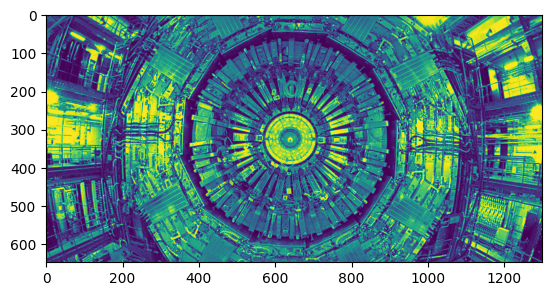

In [6]:
# Load and show an image

img = mpimg.imread('codas-hep-intro-ml-2023/part3/assets/experiment.jpg')

plt.imshow(img[:, :, 0]);

# The CMS detecor:

A lot of filters were hand-crafted a long time ago. Apps on your phone are often still using these man-made kernes. We are going to to use an classic edge detection filter: a Sobel filter. You can read more about it [here](https://en.wikipedia.org/wiki/Sobel_operator).

In [7]:
# Define our filter

sobel_filter = np.array(
    [
        [ 1,  2,  1],
        [ 0,  0,  0],
        [-1, -2, -1]
    ]
)

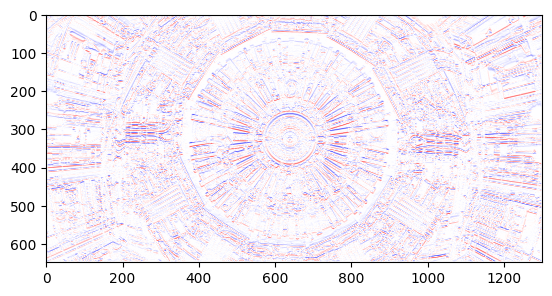

In [8]:
# Perform our convolution and show the result

img_edges = convolution(img[:, :, 0], sobel_filter)

plt.imshow(img_edges, cmap='bwr');

The edges should be red or blue colored (depending on the direction of change), gray areas mean no edge. We have used a vertical variant of the sobel filter. We can see the edges quite clear. Let's try to see if there is any difference when we apply a horizontal version.

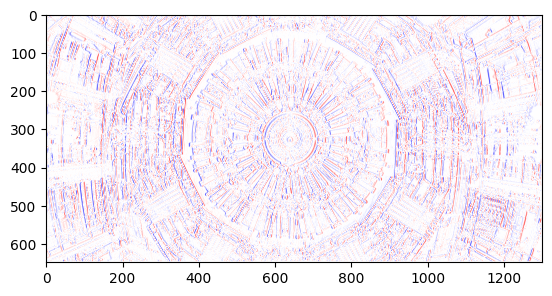

In [9]:
# Perform our convolution and show the result

img_edges = convolution(img[:, :, 0], sobel_filter.T)

plt.imshow(img_edges, cmap='bwr');

Let's do a check if our input image shape matches the shape of the output one:

In [11]:
assert img[:, :, 0].shape <= img_edges.shape

We should expect that because we didn't apply any padding. There are two important parameters that we did not implement, i.e. stride and padding. **Stride** contols by how many pixels do we move in every loop. **Padding** expands the input by adding border to the image.

**Your task**: implement padding (*and optionally stride*). You could use `np.pad` method.

### Pooling Operation

Pooling layers are used to reduce the dimensions of the feature maps, which reduces number of learnable parameters and speeds forward and backward pass. The operation slides a filter over the feature map which either outputs and average or max.

In [12]:
def pooling(img, size):
    # Mind that I used size as stride as in preactis they are often equal.

    H = img.shape[0] # height of the image
    W = img.shape[1] # width of the image

    img_out = np.zeros((H//size, W//size))

    # Nested loops over V and U
    for v in range(0, H//size):
        for u in range(0, W//size):
            img_out[v, u] = np.max(img[v*size:v*size+size, u*size:u*size+size])
    return img_out

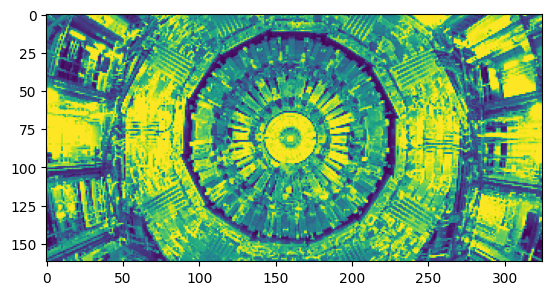

In [13]:
# Perform our pooling and show the result

img_pool = pooling(img[:, :, 0], 4)

plt.imshow(img_pool);

## Jet Tagging: Introduction

The majority of particles produced in LHC events are unstable and immediately decay to lighter particles. The new particles can decay themselves to others in a so-called decay chain. Such a process terminates when the decay products are stable particles, e.g., charged pions. This collimated shower of particles with adjacent trajectories is called a *jet*. Jets are central to many physics studies at the LHC experiments. In particular, a successful physics program requires aggregating particles into jets (jet clustering), an accurate determination of the jet momentum (momentum measurement) and the identification of which particle kind started the shower (**jet tagging**).

In this excercise you will learn how to train and evaluate a classifier that will predict which particle produced a given jet, a *jet tagger*. We will classify jets to five classes: produced by decay of top (*t*), Z (*z*) and W (*w*) boson, gluon (*g*) and quark (*q*).

### Preparation of the training and validation samples

If you have already downloaded the datasets you can skip the cell below and. In order to import the dataset: clone the dataset repository (to import the data in Colab), load the `h5` files in the data/ repository, extract the data we need: a target and jetImage.

To type shell commands, we start the command line with !

In [14]:
 ! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o ../Data-MLtutorial.tar.gz
 ! tar -xvzf ../Data-MLtutorial.tar.gz -C ../
 ! ls ../Data-MLtutorial/JetDataset/
 ! rm ../Data-MLtutorial.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  18.8M      0 --:--:--  0:00:17 --:--:-- 26.9M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_50000_60000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_60000_70000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_40000_50000.h5	jetImage_7_100p_80000_90000.h5


In [15]:
# Load the dataset

target = np.array([])
inputs = np.array([])

datafiles = ['../Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             '../Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             '../Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             '../Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']

for file_ in datafiles:
    with h5py.File(file_, 'r') as f:
        print("Appending {}".format(file_))
        tmp_jet_img = np.array(f.get("jetImage"))
        tmp_target = np.array(f.get('jets')[0:,-6:-1])
        inputs = np.concatenate([inputs, tmp_jet_img], axis=0) if inputs.size else tmp_jet_img
        target = np.concatenate([target, tmp_target], axis=0) if target.size else tmp_target

print(target.shape, inputs.shape)

Appending ../Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending ../Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending ../Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending ../Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(40000, 5) (40000, 100, 100)


Each `target` row is a one-hot encoded class, where the labels correspond to this order: `['gluon', 'quark', 'W', 'Z', 'top']`. For example $[1, 0, 0, 0, 0]$ means gluon and $[0, 0, 0, 0, 1]$ top jet.

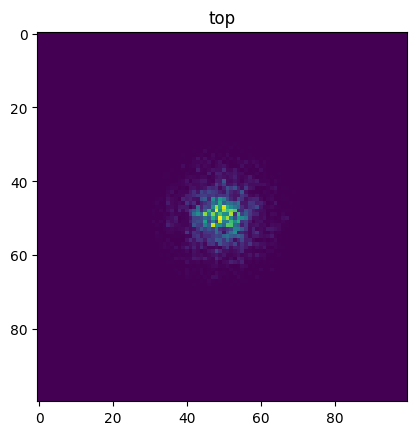

In [16]:
# Let's see how does the top boson looks like

average_w = np.mean(inputs[:1000][target[:1000, -1] == 1], axis=0)
plt.title('top')
plt.imshow(average_w);

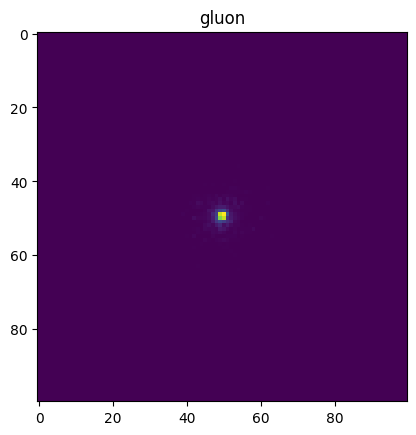

In [17]:
# And here is an average of gluon?

average_gluon = np.mean(inputs[:1000][target[:1000, 0] == 1], axis=0)
plt.title('gluon')
plt.imshow(average_gluon);

Let's prepare the dataset for training...

In [18]:
# Train, Validation, Test split

X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(24000, 100, 100)
(8000, 100, 100)
(8000, 100, 100)
(24000, 5)
(8000, 5)
(8000, 5)


In `keras`, images are represented as $n \times m \times k$ tensors, where $n \times m$ are the pixel dimenions and $k$ is the number of channels (e.g., 1 in a black\&while image, 3 for an RGB image). In our case, k=1. To comply to this, we add the channel index by reshaping the image dataset

In [19]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(24000, 100, 100, 1)
(8000, 100, 100, 1)
(8000, 100, 100, 1)


In [20]:
# Keras imports

from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, Activation

In [21]:
# Define your CNN architecture using Keras functional API

input_ = Input(shape=(100, 100, 1))
x = Conv2D(5, kernel_size=(5, 5), data_format="channels_last", strides=(1, 1), padding="same")(input_)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size = (5, 5))(x)
x = Dropout(0.25)(x)
x = Conv2D(3, kernel_size=(3, 3), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (3,3))(x)
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(5, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=input_, outputs=output)

In [22]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Print model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 5)       130       
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 5)      20        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100, 100, 5)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 20, 20, 5)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 20, 20, 5)         0     

We now train the model. This takes really long time and processing power on common CPUs. If you are running locally set `EPOCHS=1` just to continue.

In [24]:
EPOCHS = 1

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=32,
    verbose=2,
    validation_data=(X_val, y_val)
)

750/750 - 119s - loss: 1.4113 - val_loss: 1.3524 - 119s/epoch - 159ms/step


In [25]:
# Save the trained model

with open("../Data-MLtutorial/jetTagger_CNN.json", "w") as json_file:
    json_file.write(model.to_json())
model.save_weights("../Data-MLtutorial/jetTagger_CNN.h5")

with open('../Data-MLtutorial/history.h5', 'wb') as f:
    pickle.dump(history.history, f, protocol=pickle.HIGHEST_PROTOCOL)

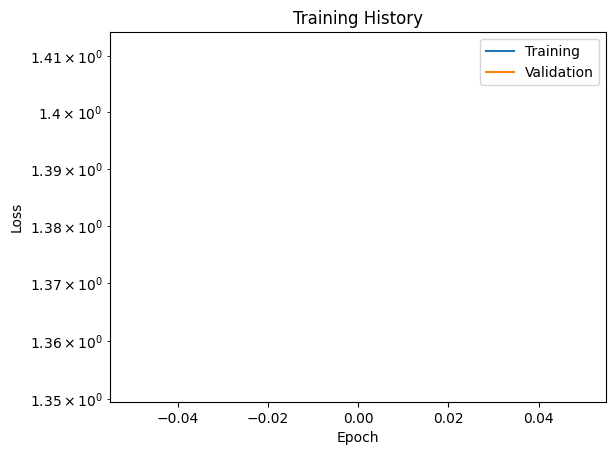

In [26]:
# Plot training history

history = history.history
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

250/250 [==============================] - 14s 54ms/step


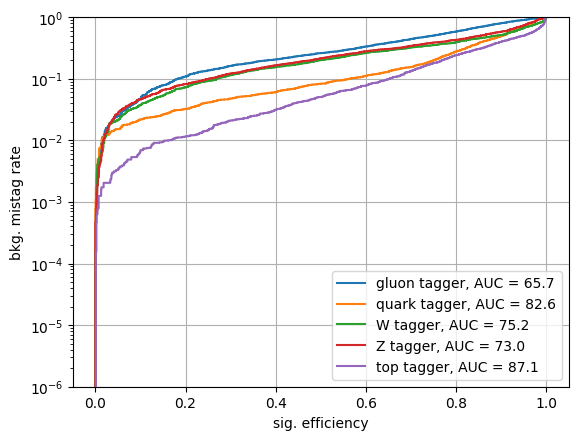

In [27]:
# Plot ROC curve and corresponding AUC

from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test)

plt.figure()
for i, label in enumerate(['gluon', 'quark', 'W', 'Z', 'top']):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    plt.plot(tpr, fpr, label='{0} tagger, AUC = {1:.1f}'.format(label, auc(fpr, tpr)*100.))

plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001, 1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

## Variational Autoencoders

Variational Autoencoders (VAEs) learn a latent variable model the input data. Instead of having a deterministic mapping like in vanilla autoencoder, VAE learns a probability distribution over the latent variables. When sampling from this distribution, we can generate new, artificial data samples. Hence, we say that a VAE is a generative model. Let's write a VAE model.

In [28]:
import tensorflow
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Input, Flatten, Dense, Lambda, Reshape, Conv2D, Conv2DTranspose

We need to define a function that takes in the mean and log variance parameters and return a random sample from the resulting distribution.

In [29]:
def sampling(args):
    mean, logvar = args
    eps = K.random_normal([latent_dim])
    rnd_sam = mean + K.exp(logvar/2) * eps
    return rnd_sam

Let's write the encoder

In [30]:
# Encoder
enc_input = Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, 3, padding='same', strides=2, activation='relu')(enc_input)
x = Conv2D(64, 3, padding='same', strides=2, activation='relu')(x)
x = Flatten()(x)
x = Dense(16)(x)

# Latent space
latent_dim = 2
z_mean = Dense(latent_dim, name='Z-mean')(x)
z_logvar = Dense(latent_dim, name='Z-logvariance')(x)

z = Lambda(sampling, output_shape=latent_dim, name='latent-space')([z_mean, z_logvar])

encoder = Model(enc_input, z, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

In [31]:
# Decoder
dec_input = Input(shape=(latent_dim,), name='decoder_input')

y = Dense(7 * 7 * 64)(dec_input)
y = Reshape(target_shape=(7, 7, 64))(y)
y = Conv2DTranspose(64, 3, padding='same', strides=2, activation='relu')(y)
y = Conv2DTranspose(32, 3, padding='same', strides=2, activation='relu')(y)
y = Conv2DTranspose(1, 3, padding='same', activation='sigmoid')(y)

decoder = Model(dec_input, y, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

We trained the model with a loss consisting of two parts. A reconstruction part forces the decoded samples to match the initial inputs. The KL-divergence between the learned latent distribution and the prior distribution (Gaussian), acting as a regularization term.

In [32]:
def loss_func(z_mean, z_logvar):

    def vae_reconstruction_loss(y_true, y_pred):
        return K.mean(K.sum(K.square(y_true - y_pred), axis=[1, 2]))

    def vae_kl_loss(z_mean, z_logvar):
        return -0.5 * K.mean(1.0 + z_logvar - K.square(z_mean) - K.exp(z_logvar), axis=1)

    def vae_loss(y_true, y_predict, beta=1):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)
        return reconstruction_loss + beta * kl_loss

    return vae_loss

Note: it is very common to introduce a $\beta$ parameter that regulates the strength of the second term. It is very common that KL-divergence falls to the prior completetely, i.e. `kl_divergence = 0`. This prevents the model to learn anything useful. To combat that we set $\beta < 1$ and commonly increase it after initial phases of the training.

In [33]:
# Connecting encoder and decoder

enc_output = encoder(enc_input)
dec_output = decoder(enc_output)

vae = Model(enc_input, dec_output, name='VAE')
vae.summary()

opt = tensorflow.keras.optimizers.Adam()
vae.compile(optimizer=opt, loss=loss_func(z_mean, z_logvar))

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        (None, 2)                 69076     
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


For this exercise we will use the MNIST dataset.

In [34]:
# Load samples of the digits

(X_train, y_train), (X_test, y_test) = tensorflow.keras.datasets.mnist.load_data()

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))

11490434/11490434 [==============================] - 0s 0us/step


In [35]:
# Train VAE

history = vae.fit(
    X_train,
    X_train,
    epochs=30,
    batch_size=128,
    validation_data=(X_test, X_test)
    )

Epoch 1/30
469/469 [==============================] - 68s 140ms/step - loss: 89.5419 - val_loss: 89.4001
Epoch 2/30
469/469 [==============================] - 65s 140ms/step - loss: 87.8660 - val_loss: 89.4001
Epoch 3/30
469/469 [==============================] - 66s 140ms/step - loss: 87.8661 - val_loss: 89.4001
Epoch 4/30
469/469 [==============================] - 66s 141ms/step - loss: 87.8660 - val_loss: 89.4001
Epoch 5/30
469/469 [==============================] - 66s 140ms/step - loss: 87.8661 - val_loss: 89.4001
Epoch 6/30
469/469 [==============================] - 68s 145ms/step - loss: 87.8660 - val_loss: 89.4001
Epoch 7/30
469/469 [==============================] - 66s 141ms/step - loss: 87.8661 - val_loss: 89.4001
Epoch 8/30
469/469 [==============================] - 66s 141ms/step - loss: 87.8660 - val_loss: 89.4001
Epoch 9/30
469/469 [==============================] - 66s 141ms/step - loss: 87.8660 - val_loss: 89.4001
Epoch 10/30
469/469 [==============================] - 

### VAEs: Generating New Samples

1/1 [==============================] - 0s 23ms/step


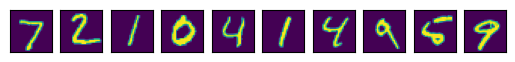

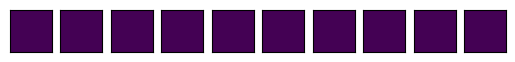

In [36]:
# Let's plot a few samples

figure1, axis1 = plt.subplots(1, 10)
figure2, axis2 = plt.subplots(1, 10)

for i in range(10):
    axis1[i].get_xaxis().set_visible(False)
    axis1[i].get_yaxis().set_visible(False)
    axis1[i].imshow(X_test[i])

    axis2[i].get_xaxis().set_visible(False)
    axis2[i].get_yaxis().set_visible(False)
    axis2[i].imshow(vae.predict(X_test[i].reshape(1, 28, 28, 1)).reshape(28,28))

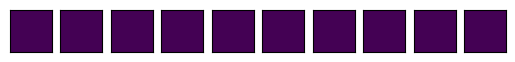

In [37]:
# Let's try to generate few new samples using out decoder

figure1, axis1 = plt.subplots(1, 10)

code_for_A = encoder(X_test[0].reshape(1, 28, 28, 1))[0]
code_for_B = encoder(X_test[2].reshape(1, 28, 28, 1))[0]

code_for_A = code_for_A.numpy()
code_for_B = code_for_B.numpy()

interpolation = np.linspace(code_for_A, code_for_B, 10)

for i, code in enumerate(interpolation):
    img = decoder(code.reshape(1, 2))
    axis1[i].get_xaxis().set_visible(False)
    axis1[i].get_yaxis().set_visible(False)
    axis1[i].imshow(img.numpy().reshape(28, 28))